# Phys 481 Fall 2021 Assignment 4: The Ising Model
### A.G. Swadling (30098501)
### E.J. Thompson (30087678)
### G.J. Gelinas (30085897)
### T.J. Cey (30088060)

In [1]:
# load libraries for numerical methods and plotting
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
%matplotlib inline

# Load other libraries 
import urllib.request
import mpmath as mp
from matplotlib import animation, rc
from IPython.display import HTML
from IPython.display import Markdown as md
from IPython.display import display
import math
import time, timeit

import seaborn as sns
sns.set(palette="bright")
plt.style.use('seaborn-pastel')

%matplotlib notebook

## Introduction

In this assignment we sought to investigate the evolution of a collection of magnetic dipoles due to various factors such as an external magnetic field, coupling between neighboring dipoles, and the temperature of the system. The analysis was simplified slightly by only consider dipoles and magnetic fields which were either parallel or anti-parallel, with either case being decided by the sign of the magnetic field and the spin of the individual dipoles. This simplified the expression for the potential energy of a dipole due to an external magnetic field to the form $$U = -mBS$$ where $m$ is the dipole moment, $B$ is the external magnetic field, and $S$ is the spin of the dipole with $S = +1$ denoting up spin and $S = -1$ denoting down spin. The distribution of spin up and spin down dipoles is determined by the Boltzmann probability distribution which reads $$p(\mathbf{x}) \propto \exp\left(-\frac{E(\mathbf{x})}{k_BT}\right)$$ where $E(\mathbf{x})$ is the energy of the system, $k_B$ is the Stefan-Boltzmann constant, and $T$ is the temperature. The normalization constant for this distribution is given by the reciprocal of the partition function $$\mathcal{Z} = \sum_{i=1}^n\exp\left(-\frac{E_i}{k_BT}\right)$$ if there are $n$ possible energy states. 

In our first task we analyzed this probability distribution by calculating all of the possible energy states for a system of $N$ uncoupled dipoles in a magnetic field $B$, and then using them to determine probabilities for each state. Then, after calculating the probabilities a random energy state was picked using the Boltzmann distribution, and the efficiency of the algorithm associated with this process was examined.

Next we investigated a more efficient method for determining if a dipole in a system should flip, known as the Metropolis-Hasting's Algorithm, which flips a particular dipole in a system based off of a probability $$p = \min\left(1,\exp\left(-\frac{\Delta E}{k_BT}\right)\right)$$ where $\Delta E = E_f - E_i$ is the difference in the system's energy between the original state, $E_i$, and the state with the dipole of interest flipped, $E_f$. This algorithm was implemented and tested before being used to evolve a ring of weakly coupled dipoles, with coupling energy $$E_i = -J(S_{i-1}S_i+S_{i+1}S_i)$$ where $J$ is a coupling constant, $S_i$ is the spin of the dipole of interest, and $S_{i-1}$ and $S_{i+1}$ are the spins of its neighbors. Finally, we extended this method to a 2D lattice of magnetic dipoles using the Ising Model, where the any dipole is weakly coupled with its four immediate neighbors in the lattice. This extension was then used to investigate the state of the lattice for various external magnetic fields, as well as for negative coupling. The average magnetization of the lattice was also investigated for a range of coupling constants to Boltzmann temperatures, $J/k_BT$, and the effect of Hysterisis on the dipole lattice as the magnetic field is swept between positive and negative values was analyzed and plotted.

## Task 1.1
Write a Python function which will calculate all of the energy states and probabilities for an arbitrary number of $N$ independent dipoles.  Tabulate the results for $N=3$, $\beta=0.1$ and $B=2$

In [2]:
def E_States(N, state, config = None): 
    
    '''This function uses recursion to determine all possible energy states for 
    a number N of independent dipoles'''
    
    states = []
    
    #for the first run of the loop initializing the configurations
    if config == None: config = []

    # recursion loop for all states in the possible states 
    for i in state:
     
        #adds -1 or 1, depending on n, onto the configurations list
        config.append(i)
        
        #if the number of independent dipoles is 1 add on -1 or 1 to the configurations list
        if N == 1 or N ==0:
            states.append(tuple(config))
        
        #if N is greater than 1, here is where the recursion happens 
        else: 
            #looking at next "independent dipole"
            state_i = E_States(N-1, state, config = config)
            
            #making the list of actual configurations
            states.extend(state_i)
        
        #getting rid of the state we added on to the list at the beginning of this loop
        config.pop()

    
    return np.array(states)


def energy_list(N, beta, B, statelist):
    
    '''Function for determining a list of all the energy states'''
    
    energylist = []
    
    #finds our energy values 
    for item in statelist:
        
        #finding energy
        E = -np.sum(item) * B
        
        energylist.append(E)
         
    return energylist


def un_norm_probs(N, beta, B, statelist):
    '''Function for determining a list of all un-normalized probabilities'''
    
    p_unnorm_list = []
    
    energylist = energy_list(N, beta, B, statelist)
    
    for item in energylist:
        
        #finding un-normalized probability 
        p_un_norm = math.exp(-1 * item * beta)
        
        p_unnorm_list.append(p_un_norm)
        
    return p_unnorm_list



def pnorm_function(N, B, T, statelist, k_b = 1.0):
    '''Finds normalized probabilities'''
    
    #determines beta
    beta = 1/(T * k_b)
    
    #finds lists for energy and un-normalized probabilites
    energylist = energy_list(N, beta, B, statelist)
    unnorm_list = un_norm_probs(N, beta, B, statelist)
    
    #initalizes list for probablites
    p_list = []
    
    #finds zeta value 
    zeta = np.sum(unnorm_list)
    
    #determines a list of normalized probabilites
    for item in energylist:
         
            p_norm = math.exp(-item*beta)/zeta
            
            p_list.append(p_norm)
    
    return(p_list)


    
def tables(N, T, B, k_b =1 ):
    '''Makes a pretty table'''

    beta = 1/(T * k_b)
    
    statelist = E_States(N, [-1, +1])
    
    energylist = energy_list(N, beta, B, statelist)
    
    probslist = pnorm_function(N, B, T, statelist)
    
    # Initializes a string for formatting a table
    format_string = "| States | System Energy | Probability | \n |-----|-----|-----| \n"
    
    # Adds each row for each possible configeration of N states
    for i in range(len(statelist)):
        format_string += f"| {statelist[i]} | {energylist[i]} | {probslist[i]:.4f} | \n"
        
    # Displays the table
    display(md(format_string))
    
    return

In [3]:
tables(3, 10, 2)

| States | System Energy | Probability | 
 |-----|-----|-----| 
| [-1 -1 -1] | 6 | 0.0646 | 
| [-1 -1  1] | 2 | 0.0964 | 
| [-1  1 -1] | 2 | 0.0964 | 
| [-1  1  1] | -2 | 0.1438 | 
| [ 1 -1 -1] | 2 | 0.0964 | 
| [ 1 -1  1] | -2 | 0.1438 | 
| [ 1  1 -1] | -2 | 0.1438 | 
| [1 1 1] | -6 | 0.2146 | 


## Task 1.2

Write a Python function which will return a Boltzmann random state for an arbitrary number $N$ of independent dipoles.  Plot the time required to produce the result as a function of $N$.  Discuss your results.

In [4]:
def random_state(N, B, T):
    '''Function for determining a random state'''

    statelist = E_States(N, [-1, +1])
        
    p_norm_list = pnorm_function(N, B, T, statelist)
    
    states = [str(state) for state in statelist]
    
    
    #1 returns a single random state
    state = np.random.choice( states , 1, p_norm_list)
    
    return(state)



def plot_Nvt(N_max, B, T):
    
    time_list = []

    for q in range(0, N_max):
    
        start = time.time()
        random_state(q, B, T)
        end = time.time()
    
        time_tot = end-start
    
        time_list.append(time_tot)

    plt.plot(range(1,N_max+1), time_list, 'purple')
    plt.title("Time required to produce a random state as a function on N")
    plt.xlabel("N")
    plt.ylabel("Time (s)")

    return

<IPython.core.display.Javascript object>


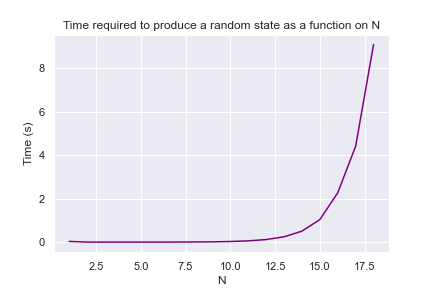

In [5]:
plot_Nvt(18, 2, 10)

## Metropolis
Use the metropolis algorithm to generate a sequence of states for a single dipole with T=300K, dE=0.01, 0.1, 1, 10eV.  Calculate the expected probabilities for each state and compare to the computed results for 1000 iterations.

In [6]:
def find_states(dE, T, k_b = 1.0):
    '''Calculate the states and propabilities associated with each state for 1000 generations of
    flipping a single dipole'''
    
    state = 1
    ngens = 1000
    p = np.minimum(1,np.exp(-dE/(k_b*T)))
    state_list = []
    prob_list = []
    
    for num_of_states in range(ngens):
        u = np.random.rand() #Define a random variable between 0 and 1 to compare against p
        
        if u < p:
            state = -state
            
        state_list.append(state)
        prob_list.append(p)
        
        p = np.minimum(1,np.exp(-(dE*state)/(k_b*T)))
        
    return state_list, prob_list


def overall_prob(states):
    '''Calculate the probability that a given dipole is spin up using a list of states'''
    
    up = 0 #Initialize the counter
    
    #For every state in the list, if it is spin up, count it
    for i in states:
        if i == 1:
            up = up + 1
            
    #Calculate probability of a dipole being spin up
    prob_up = up/len(states)
            
    return prob_up

In [7]:
dE_list = [0.01, 0.1, 1, 10] #List of energy changes to cycle through (eV)

states_001, probs_001 = find_states(dE_list[0], 300)
states_01, probs_01 = find_states(dE_list[1], 300)
states_1, probs_1 = find_states(dE_list[2], 300)
states_10, probs_10 = find_states(dE_list[3], 300)

#Get compuatational probabilities that a dipole is spin up for every dE of interest
prob_up_states_001 = overall_prob(states_001)
prob_up_states_01 = overall_prob(states_01)
prob_up_states_1 = overall_prob(states_1)
prob_up_states_10 = overall_prob(states_10)

#Display the calculated probability for spin up and spin down for a given dipole in a table
calc_prob = tables(1, 300, 0.0)


#Display said computational probabilities to user
print("Computational probability of a dipole being spin up (dE = 0.01 eV):", prob_up_states_001)
print("Computational probability of a dipole being spin up (dE = 0.1 eV):", prob_up_states_01)
print("Computational probability of a dipole being spin up (dE = 1 eV):", prob_up_states_1)
print("Computational probability of a dipole being spin up (dE = 10 eV):", prob_up_states_10)

| States | System Energy | Probability | 
 |-----|-----|-----| 
| [-1] | 0.0 | 0.5000 | 
| [1] | -0.0 | 0.5000 | 


Computational probability of a dipole being spin up (dE = 0.01 eV): 0.5
Computational probability of a dipole being spin up (dE = 0.1 eV): 0.5
Computational probability of a dipole being spin up (dE = 1 eV): 0.501
Computational probability of a dipole being spin up (dE = 10 eV): 0.512


As seen above, when finding the probability that a given dipole is spin up, all computed probabilities are very similar, being very close to 0.5. When the energy difference is increased, we see a corresponding increase in the probability that the dipole is spin up (which in turn would be mean the probability that a dipole is spin down would be decreased). This difference in probability with increased dE is small, with the probabilties when dE is 0.01 eV or 0.1 eV being consistently 0.5, the probability when dE = 1 eV usually being 1 but sometimes going to 0.502, and with the probability when dE = 10 eV usually differing form 0.5 on the order of thousandths, however on one run it was seen to go as high as 0.511. This consistency difference indicates that for larger dE, 1000 generations is not sufficient to get a firm and reliable value for the probability and we should use more in the future. However, even with these small changes present, it is clear that the computational and calculated value displayed in the table of 0.5000 agree and our computational method is valid.

## Task 2.1: 
Write python code to evolve a system of $N$ dipoles in a ring (wrap-around boundary conditions) using the Metropolis algorithm for arbitrary $N$, $B$, $T$, $J$.

In [8]:
def evolve(N, B, T, J, ngens = 500, m=1.0, k_b = 1.0):
    '''This function will evolve the ring. m and k_b are defined to be 1 here'''
    
    beta = 1/(k_b*T) #Define beta
    
    states = np.zeros(N) #List of N zeros, initialized list of states. To be updated
    
    #Use the probability relationship to fill the initial list of states with reasonable values
    p_array = np.random.rand(N) #N length array of random numbers between 0 and 1 for probabilities
    p = np.random.rand() #Gets a singular probability that we will compare to each element in a_array
    
    #[p_array > p] checks if each element is greater than p, if so, it sets the corresponding element
    #in states to 1
    states[p_array >= p] = 1 
    
    states[p_array < p] = -1 # Applies same idea as above but checks if less than p and sets to -1
    
    #Calculates the energy required to align a given magnetic dipole in a given magnetic field for all
    #listed states
    EB_list = -1.0*m*B*states
    
    #Cycle through all elements in states. np.roll(states,n) shifts each element by n
    E_i = -J*np.roll(states,1)*states - J*np.roll(states, -1)*states
    
    grid = np.zeros((ngens,N))
    grid[0,:] = states
    
    
    for i in range(1,ngens):
        index = np.random.randint(low = 0, high = N) #Choose a random index within the states list
        
        #Calculate the energy for a given dipole before any flipping
        E_0 = np.sum(EB_list) + np.sum(E_i)
        
        E_B1 = np.copy(EB_list) #Make a copy of the list of base energies
        E_B1[index] = -E_B1[index] #Flip the state of 1 random index
        
        #Make a copy of the list of coupled energies
        E_i1 = np.copy(E_i)
        E_i1[index] = -E_i1[index]
        
        
        E_i1[(index-1)%N] += 2*J*states[index]*states[(index-1)%N]
        E_i1[(index+1)%N] += 2*J*states[index]*states[(index+1)%N]
        
        E_1 = np.sum(E_B1) + np.sum(E_i1)
        
        prob = np.minimum(1,np.exp(-(E_1 - E_0)*beta))
        
        u = np.random.rand()
        
        if u < prob:
            states[index] = -states[index]
            
        grid[i,:] = states
        
    return grid


def plot_evolved(grid, maxcell = 200):
    '''Plots the states of the cells as they evolve to the set number of generations''' 

    plt.figure(figsize = (10,10))
    plt.imshow(grid.T)
    plt.xlim(0, maxcell)
    plt.xlabel("Generation")
    plt.ylabel("Cell number")
    plt.grid(False)

<IPython.core.display.Javascript object>


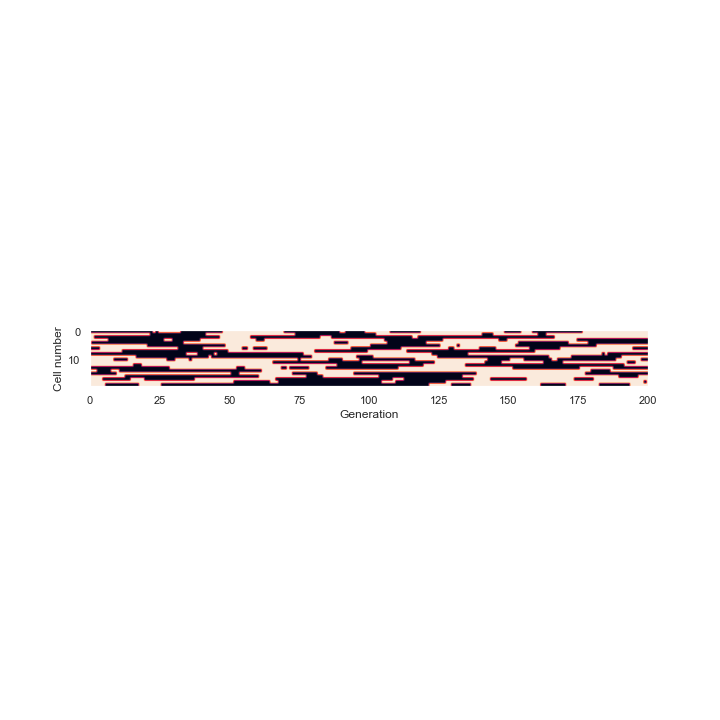

In [9]:
#Plot an evolution of dipoles for some given initial condition for visualization
plot_evolved(evolve(20,1.0,300000,1.0))

## Task 3.1:
Write python code to implement the Ising model on a 51x49 grid for arbitrary J and B.  Use 200 sweeps to thermalize and assume that the grid is randomized after 20 sweeps.

In [10]:
class DipoleLattice():
    """A lattice of magnetic dipoles in a magnetic field which are weakly coupled with each other."""
    
    def __init__(self, J = 1.0, B = 1.0, T = 1.0, M = 51, N = 49, grid = None, prob = 0.5, m = 1.0, k_b = 1.0):
        """Initialize grid and constants
        
        Arguments:
        J -- coupling constant
        B -- external magnetic field
        T -- temperature
        M -- number of rows in the grid
        N -- number of columns in the grid
        ratio_range -- range of J/Tk_b ratio
        initialize -- number of iterations to go through before returning the state grid
        m -- magnetic moment
        k_b -- boltzmann constant"""
        
        # If no grid is initialized, initialize a random grid of 1's and -1's
        if grid is None: 
            grid = np.array(2*(np.random.rand(M,N) > prob) - 1, dtype = np.int8)
        
        # Set instance variables
        self.J = J
        self.B = B
        self.T = T
        self.grid = grid
        self.m = m
        self.k_b = k_b
        self.Mag = []
        
        # Initializes proportion of grid to change for partial steps
        self.prop = 0.05
        
    
    def set_J(self, J):
        """Changes the coupling constant"""
        self.J = J
    
    def set_B(self, B):
        """Changes the external magnetic field"""
        self.B = B
        
        
    def set_T(self, T):
        """Changes the temperature"""
        self.T = T
        
    def set_prop(self, prop):
        """Changes the proportion of grid to change"""
        # Ensures the proportion is valid
        assert( prop <= 1 and prop >= 0 )
        self.prop = prop
        
    def reset_Mag(self):
        """Resets magnetization array"""
        self.Mag = []
        
        
    def update_Mag(self):
        """Append the magnetization for the current grid"""
        
        self.Mag.append(np.sum(self.grid)/np.size(self.grid))
        
        return self.Mag
    
    
    def flip_partial(self, near, xx, yy):
        """Flips the states of the whole grid simultaneously
        
        Arguments:
        near -- grid of the sum of states of neighboring dipoles
        xx -- x-coordinates of dipoles to be tested
        yy -- y-coordinates of dipoles to be tested"""
        
        # Obtains a grid of changes in energy associated to a state change of each dipole in the grid
        delta_E = 2*self.B*self.m*self.grid[xx,yy]+2*self.J*self.grid[xx,yy]*near # JUSTIFY THIS POSSIBLY IN A COMMENT
    
        # Finds the probability that the dipole will flip
        probs = np.minimum(1, np.exp(-delta_E/(self.m*self.T))) 


        # Creates a grid of 1's and -1's based on the Metropolist flip probability, where a 1 corresponds
        # to flipping the associated dipole and a -1 corresponds to leaving its state unchanged
        flip_grid = probs > np.random.rand(len(probs))
        flip_grid = 2*flip_grid-1

        # Flips the appropriate dipoles
        self.grid[xx, yy] = self.grid[xx,yy]*(-flip_grid)
        

    def ising_stepper_partial(self):
        """Iterates a portion of the grid based on the probability specified at initialization"""
        
        # Obtains an integer number of grids to test
        nx, ny = self.grid.shape
        prop_grid = int(nx*ny*self.prop)
        
        # Obtains random indexes of dipoles to be tested
        x_range = np.random.randint(nx, size = prop_grid)
        y_range = np.random.randint(ny, size = prop_grid)
        
        # Sums the states of the neighbors of each dipole we are testing
        sum_near = self.grid[(x_range+1)%nx, y_range]+self.grid[(x_range-1)%nx, y_range] \
                + self.grid[x_range, (y_range+1)%ny]+self.grid[x_range, (y_range-1)%ny]
        
        # Performs a flip test using the Metropolis algorithm
        self.flip_partial(sum_near, x_range, y_range)
        
        
    def thermalize(self, nsteps = 200, plot = False, update_Mag = False):
        """Thermalizes the lattice of dipoles by repeatedly applying the stepper.
        If plot is true animates the thermalization, and if update_Mag is true
        the magnetization of the grid is recorded."""
        for i in range(nsteps):
            # Evolves the dipole
            self.ising_stepper_partial()
            if plot:
                # Plots the current lattice with the external magnetic field
                self.ax.set(title = "Dipole Lattice, $B = {}$".format(self.B))
                self._animate_step(nsteps = 1)
            
            if update_Mag:
                # Updates the magnetization of the lattice
                self.update_Mag()
        return self.Mag
    
    def plot_grid(self):
        """Plots the current lattice of dipoles"""
        
        fig, ax = plt.subplots()
        ax.set(title = "Dipole Lattice, $B = {}$".format(self.B))
        img = ax.imshow(self.grid, interpolation = 'nearest')
        fig.show()
        #plt.colorbar(img)
        return (img,)
    
    
    # Animation functions inspired by Dr. Jackel's Game of Life code
    def _animate_init(self):
        """Initializes grid for animation"""
        self.fig, self.ax = plt.subplots()
        self.plt = self.ax.imshow(self.grid, interpolation='nearest')  
        self.fig.show()
        plt.colorbar(self.plt)
        return (self.plt,)
    
    def _animate_step(self, nsteps = 1):
        """Animates a certain number of steps"""
        for i in range(nsteps):
            self.ising_stepper_partial()
            self.plt.set_data( self.grid )
        
            self.fig.canvas.draw() ; self.fig.canvas.flush_events() #update plot window
            
        return (self.plt,)

<IPython.core.display.Javascript object>


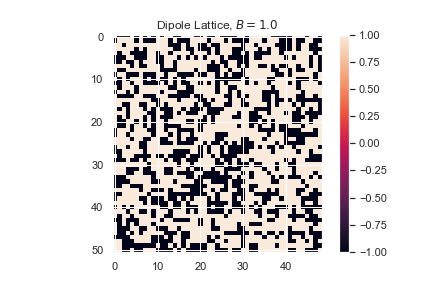

[]

In [11]:
# Tests a dipole lattice with thermalization and then plotting of the randomization
test_lattice = DipoleLattice(T = 10.0)
test_lattice.thermalize()
test_lattice._animate_init()
test_lattice.thermalize(nsteps = 20, plot = True)

In the above plot we see a sample dipole lattice after 220 runs, with a temperature of 10.0, an external magnetic field of 1.0, a coupling constant of 1.0, a magnetic moment of 1.0, and a scaled Boltzmann constant of 1.0 for simplification.

## Task 3.2: 
Produce grid plots (ie. matplotlib imshow) for B=0, B=+0.5, B=-0.5 with J=(kB T)

<IPython.core.display.Javascript object>


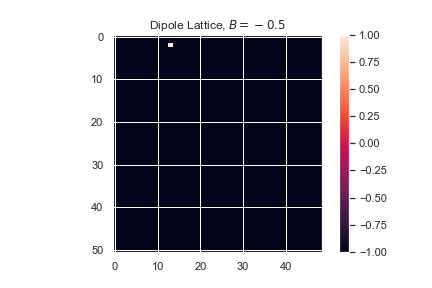

<IPython.core.display.Javascript object>


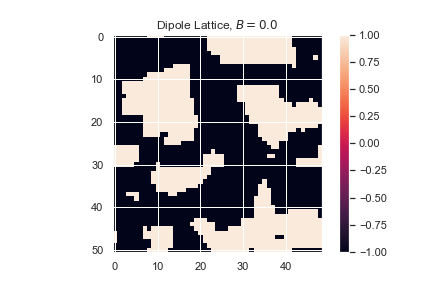

<IPython.core.display.Javascript object>


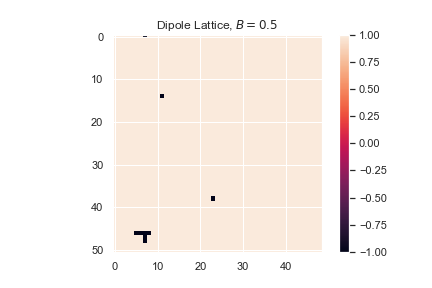

In [12]:
# Initialize array of test magnetic fields
B_array = [-0.5, 0.0, 0.5]


for B in B_array:
    # Create dipole lattice in an external magnetic field B
    mag_lattice = DipoleLattice(T = 1.5, J = 1.5, B = B)
    
    # Thermalize the lattice then animate 50 steps of the evolution
    mag_lattice.thermalize(nsteps = 200)
    mag_lattice._animate_init()
    mag_lattice.thermalize(nsteps = 50, plot = True)

Hence, we see that for a negative external magnetic field the dipoles align with spin down for the most part, while for a positive external magnetic field the dipoles align with spin up. Further, when no external magnetic field is present we see a variety of magnetic domains caused by coupling of neighboring dipoles as well as the randomness caused by the temperature of the system.

## Task 3.3:
For B=0 and J/(T kB)=range(0.0, 0.6, 21), calculate and plot the average magnetization M versus J/TkB.

In [13]:
def plot_Mag(B, ratio_range, k_b = 1.0, M = 51, N = 49, iterations = 1, num_lattices = 3):
    """Plots the average magnetization for various values of the ratio J/k_BT
    
    Arguments:
    B -- external magnetic field
    ratio_range -- list of J/k_bT values used
    k_b -- scaled Stefan-Boltzmann constant
    M -- the number of rows in the dipole lattice
    N -- the number of columns in the dipole lattice
    iterations -- number of iterations in each run
    num_lattices -- number of dipole lattices to be tested
    """
    
    # Initializes the range of coupling constants 
    J_range = ratio_range*1.0*k_b
    
    # Creates a figure with subplots for storing the magnetization plot in the top row,
    # and the final states of the dipole lattices in the bottom row
    fig = plt.figure(figsize=(8, 6))
    grid = plt.GridSpec(2, num_lattices, hspace=0.2, wspace=0.6)
    mag_ax = fig.add_subplot(grid[0, :])
    mag_ax.set(xlabel = "Coupling per unit temperature, $J/Tk_b$", ylabel = "Magnetization, $m$",
               title = "Magnetization versus $J/Tk_b$")
    lattices = [fig.add_subplot(grid[1, i]) for i in range(num_lattices)]
    
    
    # Calculates and plots the average magnetization of dipole lattices with the same initial conditions
    for i in range(num_lattices):
        
        # Keep the same lattice as the J's change?
        magno_lattice = DipoleLattice(B = B, T = 1.0, J = 1.0, k_b = k_b, M = M, N = N)
        # Initialize array of average magnetizations
        M_avgs = np.zeros(len(J_range))
        for j in range(len(J_range)):
        
            # Sets the coupling constant and thermalizes the lattice before updating
            # the magnetization over a certain number of steps
            magno_lattice.set_J(J_range[j])
            magno_lattice.thermalize(nsteps = 200)
            magno_lattice.thermalize(nsteps = iterations, update_Mag = True)
            
            # 
            M_avgs[j] = np.mean(magno_lattice.Mag)

#             # Calculates the average magnetization for the current coupling constant and resets the collection of magnetizations
#             M_avgs[j] = np.sum(Mag)/
            magno_lattice.reset_Mag()
        
        # Plots the grid for the current dipole lattice and adds the magnetization plot to the top figure
        lattices[i].imshow(magno_lattice.grid, interpolation='nearest')
        lattices[i].set(title = f"Dipole Lattice {i+1}")
        mag_ax.plot(ratio_range, M_avgs, label = f"Run #{i+1}")
    
    # Sets the magnetization plot limits and adds a legend
    mag_ax.set(xlim = (ratio_range[0], ratio_range[-1]), ylim = (-1.0, 1.0))
    mag_ax.legend()

<IPython.core.display.Javascript object>


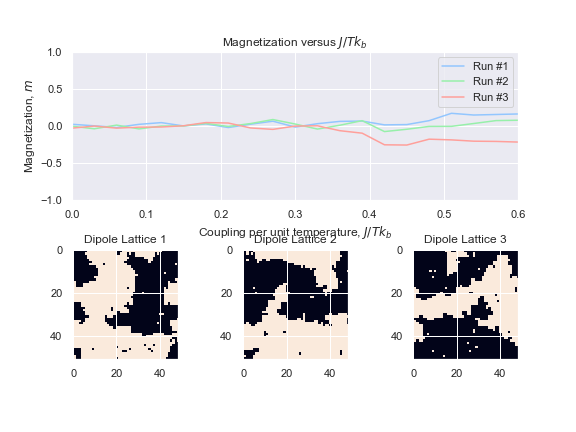

In [14]:
# Plots the magnetization grid for a specified range of coupling constant to temperature ratios, 
# with a zero external magnetic field
ratio_range = np.linspace(0.0, 0.6, 21)

plot_Mag(0.0, ratio_range)

As we can see in the magnetization plot, as the coupling constant is increased magnetic domains start to form and increase in size, causing the overall absolute value of the magnetization of the grid to increase.

## Task 3.4:
Produce a hysteresis curve over an appropriate range of external magnetic field B values.

In [15]:
def increasing_B(lattice, B_max, Avg_Mags, Magnetic_fields, iterations = 20, dB = 0.1):
    """Increments the external magnetic field up to some maximum value, recording the average 
    magnetization of the lattice at each step"""
    
    while lattice.B < B_max:
        # Increments the external magnetic field strength
        lattice.set_B(lattice.B + dB)
        Magnetic_fields.append(lattice.B)
        Mag = lattice.thermalize(nsteps = iterations, update_Mag = True)
        
        # Calculates the average magnetization for the current magnetic field and resets the collection of magnetizations
        Avg_Mags.append(np.sum(Mag)/len(Mag))
        lattice.reset_Mag()
    
    return Avg_Mags, Magnetic_fields


def decreasing_B(lattice, B_max, Avg_Mags, Magnetic_fields, iterations = 20, dB = 0.1):
    """Increments the external magnetic field up to some maximum value, recording the average 
    magnetization of the lattice at each step"""
    
    while lattice.B > -B_max:
        # Increments the external magnetic field strength
        lattice.set_B(lattice.B - dB)
        Magnetic_fields.append(lattice.B)
        Mag = lattice.thermalize(nsteps = iterations, update_Mag = True)
        
        # Calculates the average magnetization for the current magnetic field and resets the collection of magnetizations
        Avg_Mags.append(np.sum(Mag)/len(Mag))
        lattice.reset_Mag()
    
    return Avg_Mags, Magnetic_fields


def plot_Hysterisis(lattice, B_max, iterations = 20, dB = 0.1):
    """Plots a hysterisis curve for the grid of magnetic dipoles
    
    Arguments:
    lattice -- grid of dipoles to evolve in time
    B_max -- maximum magnetic field strength to range between
    iterations -- number of iterations in each run
    """
    
    # Initialize array of average magnetizations and magnetic fields
    Avg_Mags = []
    Magnetic_fields = []
    
    # Initially increases the magnetic field to max
    Avg_Mags, Magnetic_fields = increasing_B(lattice, B_max, Avg_Mags, Magnetic_fields, \
                                             iterations = iterations, dB = dB)
    
    # Decreases the magnetic field to a min, then raises it back up to a max
    Avg_Mags, Magnetic_fields = decreasing_B(lattice, B_max, Avg_Mags, Magnetic_fields, \
                                             iterations = iterations, dB = dB)
    Avg_Mags, Magnetic_fields = increasing_B(lattice, B_max, Avg_Mags, Magnetic_fields, \
                                             iterations = iterations, dB = dB)
    
    
    # Plots the hysterisis curve
    fig = plt.figure()
    ax = plt.subplot(xlabel = "External Field Strength, $B$", ylabel = "Magnetization, $m$",
                      title = "Magnetization versus External Field Strength")
    ax.plot(Magnetic_fields, Avg_Mags)

<IPython.core.display.Javascript object>


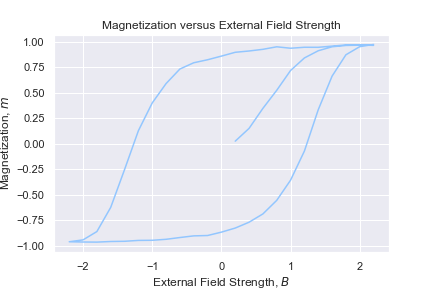

In [16]:
hysterisis_lattice = DipoleLattice(B = 0.0, J = 2.0, T = 4.5)

plot_Hysterisis(hysterisis_lattice, 2.0, iterations = 50, dB = 0.2)

Evidently, in the above plot we can see a clear hysterisis curve for dipole lattice, where the magnetization is initially increased from zero, but then as it is reduced the the magnetization of the lattice does not change greatly until the external magnetic field is negative due to the coupling of neighboring dipoles. A similar behaviour is seen when the magnetic field is increased from the negative maximum back to the positive one, with only a marginal change in the magnetization of the lattice being observed until the external magnetic field changes from negative to positive.

## Task 3.5:
Produce a grid plot for J=-kB T.

<IPython.core.display.Javascript object>


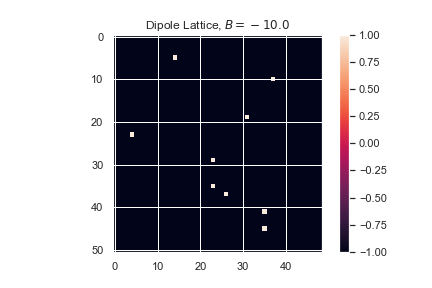

<IPython.core.display.Javascript object>


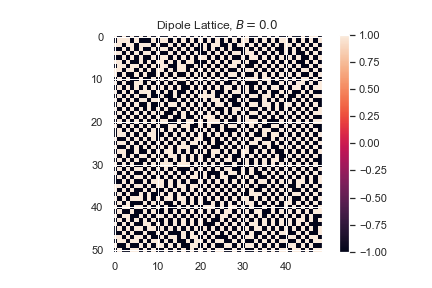

<IPython.core.display.Javascript object>


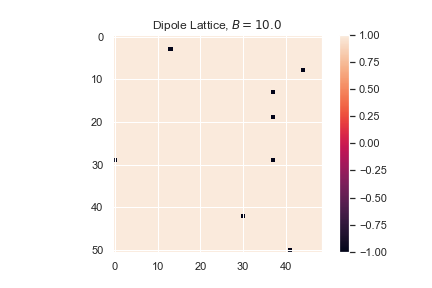

In [20]:
# Animates the evolution of a dipole lattice with negative coupling for a range of external magnetic fields
B_range = np.linspace(-10, 10, 3)

for B in B_range:
    coupling_lattice = DipoleLattice(T = 1.0, J = -1.0, B = B)
    coupling_lattice._animate_init()
    coupling_lattice.thermalize(nsteps = 50, plot = True)

## Task 3.6:
Briefly discuss all of your results.

Looking at the grid plots for varying external magentic field strnegths for low temperature conditions in 3.2, we see that the lattice possesses clear paramagnetic tendencies. The ldipoles in the lattice conform to the direction of the external magnetic field at low temperatures or form large random domains when no field is present. 

Plotting the magnetization of the lattice for a range of temperatures from very large to small comapared to the magnetic coupling reveals that the magentization of the material is very low for hight temperatures, as we would expect since high temperatures introduce high degrees of random fluctation into the system. At lower temperatures we see that the magneitzation begins to subtly increase as magnetic domains begin to form even without any external magnetic field, though they are not toally magnetized as we saw before.

The hysteresis plot in 3.4 is exactly what we would expect for a real material, where the lattice is magnetized in one direction due to an external magnetic field and remains that way until an opposite external magentic field is applied. Once a magnetic field is applied to the lattice, the coupling between the diploes in the lattice keep the domain of the lattice intact assuming that the temperature does not randomize the grid.

Finally, when the coupling constant between the dipoles is reversed (i.e. when the dipoles repel one another), we see that the lattice does not form large stable domains like before, instead forming a roughly uniform checkerboard like grid where the local magnetization of the lattice is uniformally very small everywhere. Even applied external magnetic fields like those applied in 3.2 are not enough to magnetize the lattice here, because that while the external field promotes a uniform direction, the dipoles themselves oppose any form of magnetization.

# Conclusion

We conclude that the Ising model is a valid model for magnetic dipoles as it displays the correct experimetnal behavior, and can be feasibly implemented using the Metropolis-Hastings algorithm. 

Calculations of the individual states for every possible state of system with N dipoles using a Boltzmann distribution quickly becomes far too large to calculate efficiently. Therefore the use of the Metropolis-Hastings algorithm or a similar algorithm is needed to evolve the system while keeping the aggragate distribution approximately equal to the Boltzmann distribution throughout the process. This way the distribution remains roughly constant, keeping the physical basis of our representation intact while not requiring inordinate amounts of calculations to perform.

The Metropolis-Hastings algorithm was implemented on both a 1 dimensional and a 2 dimensional grid of dipoles and displayed the behavior consistent with our expectations of the dipole lattice. The results of the 2 dimensional lattice in particular produced the expected paramagentic properties and hysteresis behavior that we would expect.